In [31]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, classification_report


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/macmini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macmini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [2]:
# Load CSV
df = pd.read_csv('../data/cleaned_for_modeling.csv')
print(f"Loaded {len(df):,} rows\n")
df.head(3)

Loaded 24,188,451 rows



,user_id,rating,text,gmap_id
0,1.067134e+20,5.0,"Easy process, extremely friendly, helpful staf...",0x80960c29f2e3bf29:0x4b291f0d275a5699
1,1.024963e+20,5.0,My girlfriends and I took a weekend ski trip t...,0x80960c29f2e3bf29:0x4b291f0d275a5699
2,1.102407e+20,5.0,The team at Black Tie never disappoints our se...,0x80960c29f2e3bf29:0x4b291f0d275a5699


### Process data

In [3]:
# Define functions

def is_likely_english(text):
    """Fast heuristic: >80% ASCII characters = likely English."""
    if pd.isna(text) or len(str(text).strip()) == 0:
        return False
    text = str(text)
    ascii_count = sum(1 for c in text if ord(c) < 128)
    return (ascii_count / len(text)) > 0.8

def filter_english_only(df):
    """Filter to English-only reviews."""
    print(f"Before English filter: {len(df):,} rows")
    df_clean = df.copy()
    df_clean['is_english'] = df_clean['text'].apply(is_likely_english)
    df_clean = df_clean[df_clean['is_english']].drop(columns=['is_english'])
    print(f"  After: {len(df_clean):,} rows ({len(df) - len(df_clean):,} removed)\n")
    return df_clean

def filter_original_tag(df):
    """Remove reviews with Google's (Original) translation tag."""
    print(f"Before (Original) tag filter: {len(df):,} rows")
    df_clean = df[~df['text'].str.contains(r'\(Original\)', na=False)].copy()
    print(f"  After: {len(df_clean):,} rows ({len(df) - len(df_clean):,} removed)\n")
    return df_clean

In [5]:
# Apply english filtering pipeline

df = (df
    .pipe(filter_english_only)
    .pipe(filter_original_tag)
    .reset_index(drop=True)
)

print(f"Final dataset: {len(df):,} rows")
df.info()

Final dataset: 22,640,876 rows
<class 'pandas.DataFrame'>
RangeIndex: 22640876 entries, 0 to 22640875
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  float64
 1   rating   float64
 2   text     str    
 3   gmap_id  str    
dtypes: float64(2), str(2)
memory usage: 690.9 MB


### Feature Engineering

In [23]:
np.set_printoptions(precision=2)

# Vectorize text data
tfidf = TfidfVectorizer(
    max_features=10000,      # Default: None | 10,000 limits vocabulary to top 10k most frequent words to reduce dimensionality and speed up training
    stop_words='english',    # Default: None | 'english' - removes common words like "the", "is", "and" that don't carry sentiment
    min_df=5,                # Default: 1 | 5 - ignores words appearing in fewer than 5 documents (removes typos/rare words)
    max_df=0.7,              # Default: 1 | 0.7 - ignores words appearing in more than 70% of documents (removes overly common words)
    ngram_range=(1, 2)       # Default: (1, 1) | (1, 2) - unigrams AND bigrams (captures phrases like "not good", "really bad")
    )

print("Fitting TF-IDF vectorizer on full dataset...")
X = tfidf.fit_transform(df.text)
y = df.rating.values

print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"Feature matrix shape: {X.shape}")
print(f"Matrix type: {type(X)}\n")

Fitting TF-IDF vectorizer on full dataset...
Vocabulary size: 10,000
Feature matrix shape: (22640876, 10000)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>



In [27]:
# Split data 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 80/20 split
                                                    random_state=22, 
                                                    stratify=y)    # matches the distribution of y

print(f"Train size: {X_train.shape[0]:,}")
print(f"Test size:  {X_test.shape[0]:,}\n")

Train size: 18,112,700
Test size:  4,528,176



### Train Model - Logistic Regression

In [29]:
print("Training Logistic Regression with CV...")
clf = LogisticRegressionCV(
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1,
    max_iter=500
)

clf.fit(X_train, y_train)


Training Logistic Regression with CV...


/Users/macmini/.venvs/base/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
/Users/macmini/.venvs/base/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1823: FutureWarning: The fitted attributes of LogisticRegressionCV will be simplified in scikit-learn 1.10 to remove redundancy. Set`use_legacy_attributes=False` to enable the new behavior now, or set it to `True` to silence this warning during the transition period while keeping the deprecated behavior for the time being. The default value of use_legacy_attributes will change from True to False in scikit-learn 1.10. See the docstring of LogisticRegressionCV for more details.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using 


Training Accuracy: 0.6938
Test Accuracy:     0.6932


### Evaluate Model

In [32]:
# Evaluate
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

# Get predictions
y_pred = clf.predict(X_test)

# F1 Score (macro average - treats all classes equally)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score (macro): {f1_macro:.4f}")

# F1 Score (weighted - accounts for class imbalance)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1_weighted:.4f}")

# Full report (precision, recall, F1 per class)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

F1 Score (macro): 0.4479
F1 Score (weighted): 0.6416

Classification Report:
              precision    recall  f1-score   support

         1.0       0.61      0.69      0.65    277522
         2.0       0.40      0.07      0.12    170567
         3.0       0.44      0.31      0.36    389717
         4.0       0.48      0.18      0.27    912304
         5.0       0.74      0.95      0.83   2778066

    accuracy                           0.69   4528176
   macro avg       0.54      0.44      0.45   4528176
weighted avg       0.64      0.69      0.64   4528176



In [16]:
# Build vocabulary and examine token frequency

# English stopwords and stemmer
stop = set(stopwords.words('english'))
ps = PorterStemmer()

def pre_processing_by_nltk(doc, stemming=True, need_sent=False):
    """Tokenize, optionally stem, and remove stopwords."""
    # Step 1: get sentences
    sentences = sent_tokenize(doc)
    # Step 2: get tokens
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        # Step 3 (optional): stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w.lower() for w in tokens if w.lower() not in stop]

# Build vocabulary from entire corpus
freq = defaultdict(int)
corpus = ' '.join(list(df['text']))
new_corpus = re.sub(r'[^\w\s]', ' ', corpus)  # Remove non-alphanumeric
raw_tokens = new_corpus.lower().split()

for token in raw_tokens:
    freq[token] += 1

# Sort by frequency
order_tokens = sorted(list(freq.items()), key=lambda x: -x[1])

print("Top 100 tokens:")
print(order_tokens[:100])

print("\nLast 500 tokens:")
print(order_tokens[-200:])

Top 100 tokens:
[('the', 21844806), ('and', 17910428), ('a', 11395901), ('to', 11385968), ('i', 11038351), ('is', 7284344), ('was', 6958265), ('it', 6633011), ('of', 6290844), ('great', 6233925), ('for', 6216723), ('good', 5459808), ('in', 5306920), ('food', 5301816), ('they', 4608360), ('you', 4180508), ('place', 4066080), ('my', 4012126), ('this', 3870001), ('service', 3822806), ('but', 3666363), ('very', 3532921), ('with', 3495147), ('are', 3243413), ('s', 3124301), ('that', 2992795), ('have', 2946298), ('on', 2839813), ('not', 2804445), ('t', 2680872), ('we', 2410371), ('there', 2338271), ('so', 2239823), ('nice', 2224966), ('at', 2189881), ('had', 2086243), ('here', 1992742), ('staff', 1861295), ('be', 1843694), ('always', 1839363), ('friendly', 1827673), ('love', 1800102), ('all', 1734224), ('were', 1708608), ('best', 1686241), ('as', 1653370), ('get', 1633912), ('time', 1616556), ('me', 1580141), ('out', 1546982), ('go', 1525888), ('like', 1523026), ('if', 1508130), ('their', 14

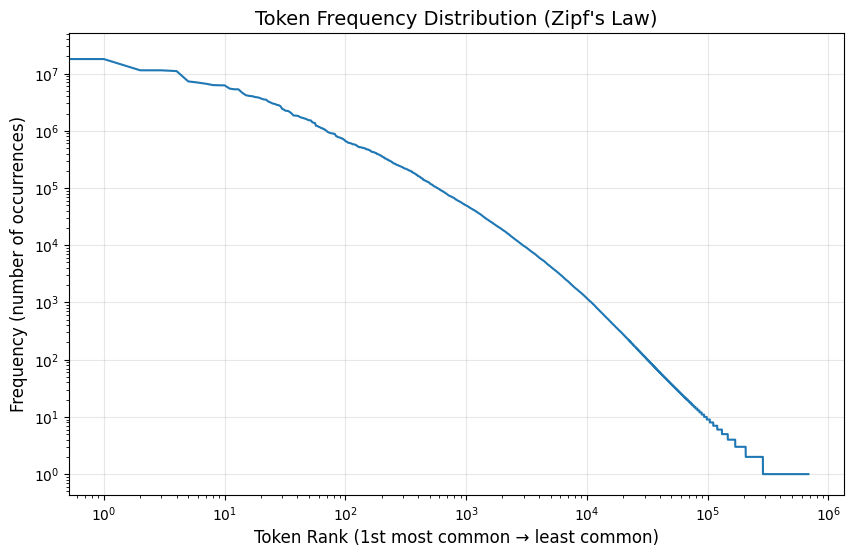


Total unique tokens: 683,031
Most common token: 'the' (21,844,806 times)
Tokens appearing only once: 396,421
Tokens appearing ≥100 times: 31,771


In [17]:
y = [freq for token, freq in order_tokens]

plt.figure(figsize=(10, 6))
plt.loglog(y)
plt.xlabel('Token Rank (1st most common → least common)', fontsize=12)
plt.ylabel('Frequency (number of occurrences)', fontsize=12)
plt.title('Token Frequency Distribution (Zipf\'s Law)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print()
print(f"Total unique tokens: {len(order_tokens):,}")
print(f"Most common token: '{order_tokens[0][0]}' ({order_tokens[0][1]:,} times)")
print(f"Tokens appearing only once: {sum(1 for _, f in order_tokens if f == 1):,}")
print(f"Tokens appearing ≥100 times: {sum(1 for _, f in order_tokens if f >= 100):,}")